In [5]:
import os
import pickle
import numpy as np
from pathlib import Path
from math import log10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model


In [75]:
# 画像のロード
def unpickle(file):
    if os.path.exists(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
            fo.close
        return dict

# cifar100
def get_cifar100(folder):
    train_fname = os.path.join(folder,'train')
    test_fname  = os.path.join(folder,'test')
    data_dict = unpickle(train_fname)
    train_data = data_dict[b'data']
    train_fine_labels = data_dict[b'fine_labels']
    train_coarse_labels = data_dict[b'coarse_labels']

    data_dict = unpickle(test_fname)
    test_data = data_dict[b'data']
    test_fine_labels = data_dict[b'fine_labels']
    test_coarse_labels = data_dict[b'coarse_labels']

    bm = unpickle(os.path.join(folder, 'meta'))
    clabel_names = bm[b'coarse_label_names']
    flabel_names = bm[b'fine_label_names']
    
    return train_data, np.array(train_coarse_labels), np.array(train_fine_labels), test_data, np.array(test_coarse_labels), np.array(test_fine_labels), clabel_names, flabel_names

# 画像にカラーノイズを入れる [N, H, W, CH]
def rand_noize_color_batch(img, noise_num):
    img2 = img.copy()

    for i in range(img.shape[0]):
        x = np.random.randint(0, img.shape[1], noise_num)
        y = np.random.randint(0, img.shape[2], noise_num)
        img2[i, x, y] = np.random.randint(0, 255, 3*noise_num).reshape(noise_num,-1)
        #img2[i, x, y] = np.random.randint(0, 255, 3)
    return img2

In [240]:
def make_noise_and_high_resolution_images(original_imgs, scale_factor=2, noise_num=1000): 
    img = original_imgs.copy()

    high_img = img.repeat(2,axis=2).repeat(2,axis=3) # ただ単に解像度だけを上げる
    high_img = high_img.transpose(0,2,3,1).astype("uint8")
    noise_img = rand_noize_color_batch(high_img, noise_num) # [N, H, W, CH]で渡す

    """"
    print("解像度を上げた画像")
    plt.imshow(high_img[0]) 
    plt.show()
    plt.imshow(high_img[1]) 
    plt.show()
    
    print("ノイズ入り画像")
    plt.imshow(noise_img[0]) 
    plt.show()
    plt.imshow(noise_img[1]) 
    plt.show()
    """
        
    #high_img = high_img.transpose(0,3,1,2)
    #noise_img = noise_img.transpose(0,3,1,2)

    return high_img, noise_img

In [254]:
# ここからメイン
datapath100 = "img/cifar-100-python/"

# 画像取り込み
tr_data100, tr_clabels100, tr_flabels100, te_data100, te_clabels100, te_flabels100, clabel_names100, flabel_names100 = get_cifar100(datapath100)

# トレーニングデータ生成
data_size = 12800
noise_num = 100

# 通常画像
X_train = tr_data100[:data_size].reshape(-1, 3, 32, 32).transpose(0,2,3,1)
X_test = te_data100[:data_size].reshape(-1, 3, 32, 32).transpose(0,2,3,1)
X_noise_train = rand_noize_color_batch(X_train, noise_num)
X_noise_test = rand_noize_color_batch(X_test, noise_num)
X_train = X_train.astype('float32') / 255.
X_test  = X_test.astype('float32') / 255.
X_noise_train = X_noise_train.astype('float32') / 255.
X_noise_test = X_noise_test.astype('float32') / 255.

# 拡大画像と拡大ノイズ入画像
original_imgs = tr_data100[:data_size].reshape(-1, 3, 32, 32)
X_train_high, X_train_noisy = make_noise_and_high_resolution_images(original_imgs, noise_num=noise_num) # [N, 3, 32, 32] -> [N, 3, 64, 64]
X_test_high, X_test_noisy = make_noise_and_high_resolution_images(te_data100[:1000].reshape(-1, 3, 32, 32), noise_num=noise_num) # [N, 3, 32, 32] -> [N, 3, 64, 64]
X_train_high = X_train_high.astype('float32') / 255.
X_train_noisy  = X_train_noisy.astype('float32') / 255.
X_test_high = X_test_high.astype('float32') / 255.
X_test_noisy = X_test_noisy.astype('float32') / 255.

In [207]:
tr_data100.shape

(50000, 3072)

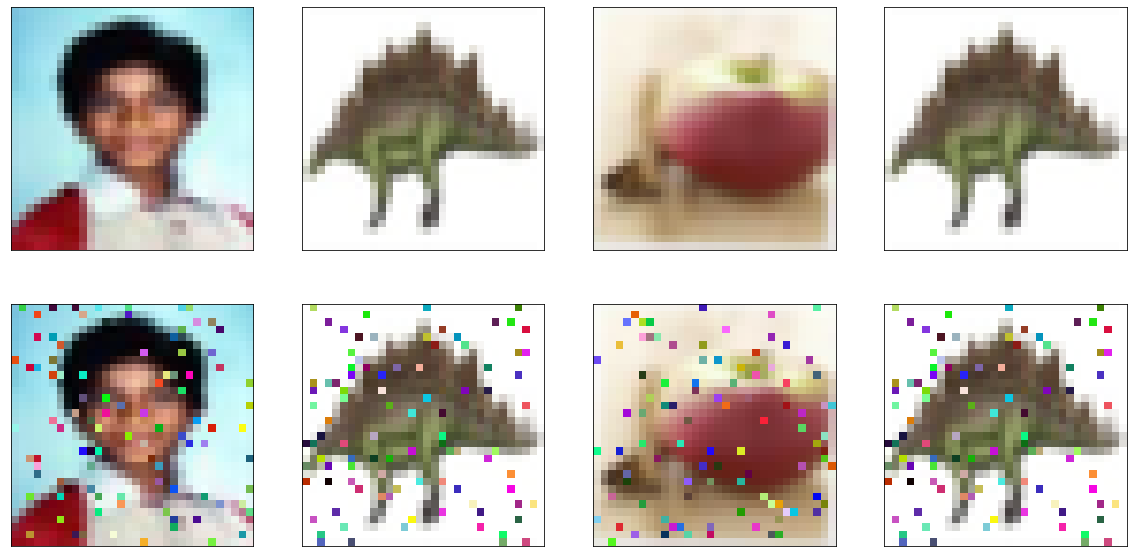

In [255]:
# ノイズがちゃんとはいっているか画像確認
n = 4
m = np.random.randint(0, 10, n)
plt.figure(figsize=(20, 10))
for i in range(m.shape[0]):
    # オリジナルのテスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_train[m[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 変換された画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(X_noise_train[m[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)  #軸の値の表示を無効化
    ax.get_yaxis().set_visible(False)  #軸の値の表示を無効化
plt.show()

In [262]:
# 32x32 +ノイズ(100)
input_img = Input(shape=(32, 32, 3))
 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
 
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_44 (UpSampling (None, 16, 16, 32)        0         
__________

In [263]:
history = autoencoder.fit(X_noise_train, X_noise_train,
                       nb_epoch=100,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(X_noise_test, X_noise_test),)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 12800 samples, validate on 10000 samples
Epoch 1/100
12800/12800 [==============================] - 26s 2ms/step - loss: 0.6099 - val_loss: 0.5850
Epoch 2/100
12800/12800 [==============================] - 25s 2ms/step - loss: 0.5807 - val_loss: 0.5764
Epoch 3/100
12800/12800 [==============================] - 24s 2ms/step - loss: 0.5765 - val_loss: 0.5741
Epoch 4/100
12800/12800 [==============================] - 24s 2ms/step - loss: 0.5737 - val_loss: 0.5719
Epoch 5/100
12800/12800 [==============================] - 24s 2ms/step - loss: 0.5723 - val_loss: 0.5705
Epoch 6/100
12800/12800 [==============================] - 26s 2ms/step - loss: 0.5711 - val_loss: 0.5698
Epoch 7/100
12800/12800 [==============================] - 25s 2ms/step - loss: 0.5702 - val_loss: 0.5687
Epoch 8/100
12800/12800 [==============================] - 24s 2ms/step - loss: 0.5695 - val_loss: 0.5688
Epoch 9/100
12800/12800 [==============================] - 24s 2ms/step - loss: 0.5689 - val_loss: 0.5

(10000, 32, 32, 3)


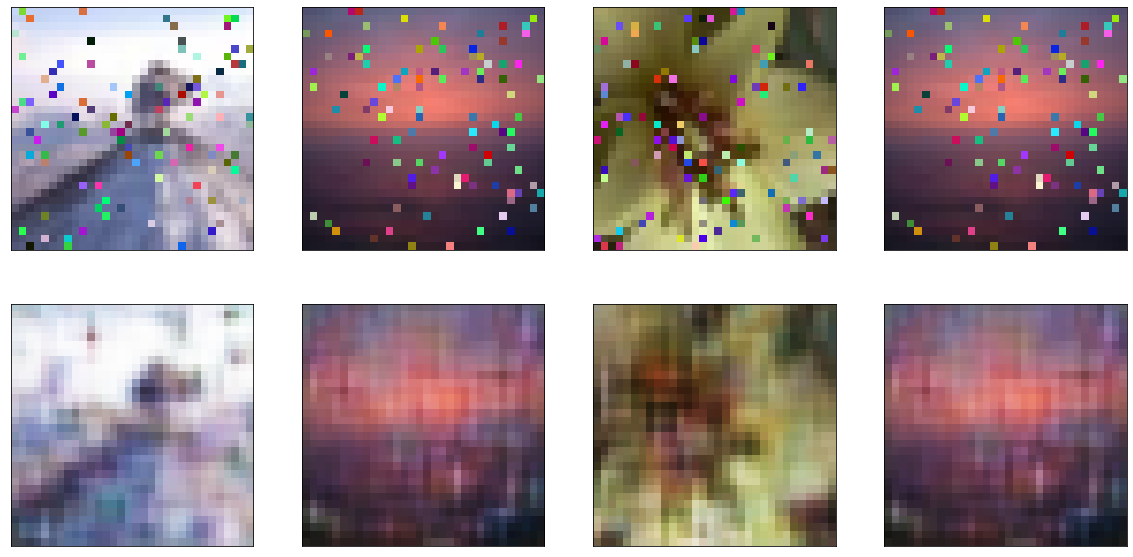

In [264]:
# テスト
decoded_imgs = autoencoder.predict(X_noise_test)
print(decoded_imgs.shape)

# 何個表示するか
# plt.subplot(行数, 列数, 何番目のプロットか)
n = 4
m = np.random.randint(0, 10, n)
plt.figure(figsize=(20, 10))
for i in range(m.shape[0]):
    # オリジナルのテスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_noise_test[m[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換された画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[m[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)  #軸の値の表示を無効化
    ax.get_yaxis().set_visible(False)  #軸の値の表示を無効化
plt.show()

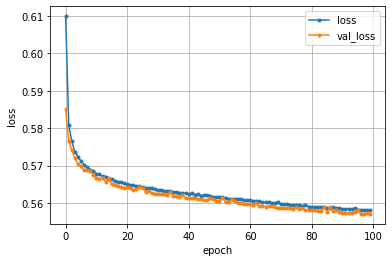

In [265]:
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [211]:
history = autoencoder_noise.fit(X_train_noisy, X_train_noisy,
                       nb_epoch=10,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(X_test_noisy, X_test_noisy),)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 12800 samples, validate on 1000 samples
Epoch 1/10
12800/12800 [==============================] - 71s 6ms/step - loss: 0.6268 - val_loss: 0.6091
Epoch 2/10
12800/12800 [==============================] - 72s 6ms/step - loss: 0.6049 - val_loss: 0.6042
Epoch 3/10
12800/12800 [==============================] - 69s 5ms/step - loss: 0.6011 - val_loss: 0.6007
Epoch 4/10
12800/12800 [==============================] - 70s 6ms/step - loss: 0.5989 - val_loss: 0.5997
Epoch 5/10
12800/12800 [==============================] - 71s 6ms/step - loss: 0.5975 - val_loss: 0.5981
Epoch 6/10
12800/12800 [==============================] - 70s 5ms/step - loss: 0.5970 - val_loss: 0.5974
Epoch 7/10
12800/12800 [==============================] - 75s 6ms/step - loss: 0.5960 - val_loss: 0.5969
Epoch 8/10
12800/12800 [==============================] - 72s 6ms/step - loss: 0.5956 - val_loss: 0.5963
Epoch 9/10
12800/12800 [==============================] - 70s 5ms/step - loss: 0.5951 - val_loss: 0.5961
Epoch 

In [244]:
# 64x64 + ノイズ(100)
input_img = Input(shape=(64, 64, 3))
 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
 
autoencoder_noise100 = Model(input_img, decoded)
autoencoder_noise100.compile(optimizer='adam', loss='binary_crossentropy')

In [245]:
history = autoencoder_noise100.fit(X_train_noisy, X_train_noisy,
                       nb_epoch=10,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(X_test_noisy, X_test_noisy),)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 12800 samples, validate on 1000 samples
Epoch 1/10
12800/12800 [==============================] - 79s 6ms/step - loss: 0.5830 - val_loss: 0.5603
Epoch 2/10
12800/12800 [==============================] - 71s 6ms/step - loss: 0.5514 - val_loss: 0.5510
Epoch 3/10
12800/12800 [==============================] - 71s 6ms/step - loss: 0.5469 - val_loss: 0.5481
Epoch 4/10
12800/12800 [==============================] - 72s 6ms/step - loss: 0.5440 - val_loss: 0.5452
Epoch 5/10
12800/12800 [==============================] - 71s 6ms/step - loss: 0.5424 - val_loss: 0.5439
Epoch 6/10
12800/12800 [==============================] - 72s 6ms/step - loss: 0.5412 - val_loss: 0.5431
Epoch 7/10
12800/12800 [==============================] - 71s 6ms/step - loss: 0.5405 - val_loss: 0.5425
Epoch 8/10
12800/12800 [==============================] - 71s 6ms/step - loss: 0.5402 - val_loss: 0.5422
Epoch 9/10
12800/12800 [==============================] - 76s 6ms/step - loss: 0.5396 - val_loss: 0.5421
Epoch 

(1000, 64, 64, 3)


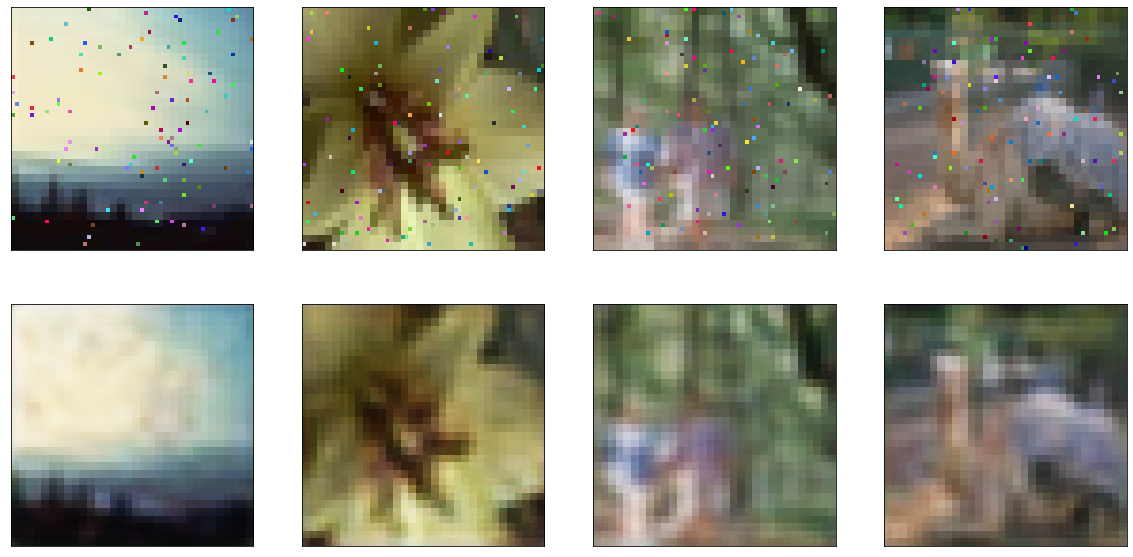

In [248]:
# テスト画像を変換
decoded_imgs = autoencoder_noise100.predict(X_test_noisy)
print(decoded_imgs.shape)

# 何個表示するか
# plt.subplot(行数, 列数, 何番目のプロットか)
n = 4
m = np.random.randint(0, 10, n)
plt.figure(figsize=(20, 10))
for i in range(m.shape[0]):
    # オリジナルのテスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_noisy[m[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換された画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[m[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)  #軸の値の表示を無効化
    ax.get_yaxis().set_visible(False)  #軸の値の表示を無効化
plt.show()

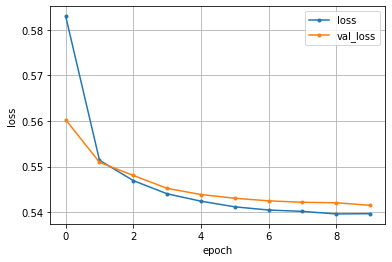

In [249]:
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [215]:
# 64x64 + ノイズ(1000)
input_img = Input(shape=(64, 64, 3))
 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
 
autoencoder_noise = Model(input_img, decoded)
autoencoder_noise.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_noise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_34 (UpSampling (None, 32, 32, 32)        0         
__________

(12800, 64, 64, 3)


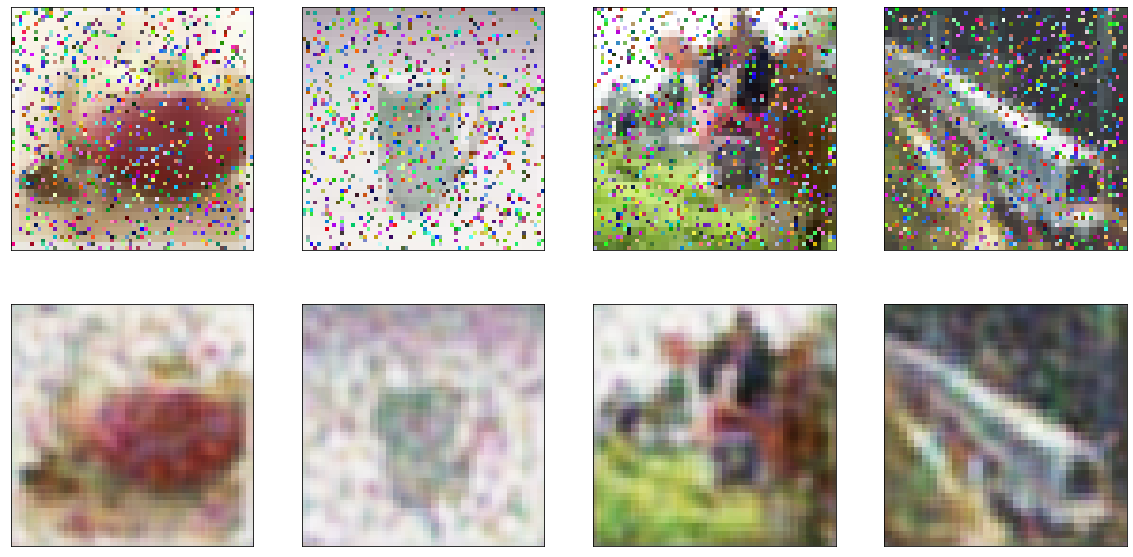

In [212]:
# テスト
decoded_imgs = autoencoder_noise.predict(X_train_noisy)
print(decoded_imgs.shape)

# 何個表示するか
# plt.subplot(行数, 列数, 何番目のプロットか)
n = 4
m = np.random.randint(0, 10, n)
plt.figure(figsize=(20, 10))
for i in range(m.shape[0]):
    # オリジナルのテスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_train_noisy[m[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換された画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[m[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)  #軸の値の表示を無効化
    ax.get_yaxis().set_visible(False)  #軸の値の表示を無効化
plt.show()

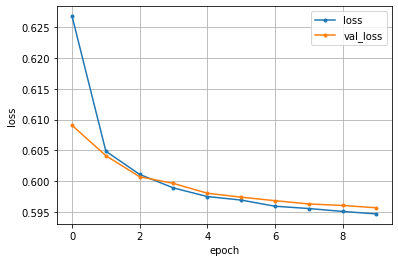

In [214]:
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()